# Intro

I think we can all agree grades are important, especially to high school students who are applying for college. College is an important step in a lot of students lives, and most of the time the odds are against them. For example, the average GPA of students being accepted to BYU is a 3.84, making it a highly competitive college to get into, especially with thousands of students applying. This means one exam score could be the make or break point for a students chances of getting into their desired school.

   Our analysis will be answering 3 research questions: 
   
   1. Can we predict final exam scores well and which features were most important?
       
   2. Can we predict final exam scores without the first exam and the second exam, and in this case which features were most important?
       
   3. Can we classify which class the student took (either Portuguese or Math), and which features were most important in classifying?


## Import Data

In [31]:
import pandas as pd
import numpy as np
from numpy import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, LassoCV, Lasso, RidgeCV
from sklearn.metrics import classification_report, accuracy_score, make_scorer, f1_score, roc_auc_score, roc_curve,mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [2]:
por = pd.read_csv("student-por.csv")

In [3]:
mat = pd.read_csv("student-mat.csv")

In [4]:
por["class"]="Portuguese"

In [5]:
mat["class"]="Math"

In [6]:
frames = [mat,por]

In [7]:
df = pd.concat(frames)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044 entries, 0 to 648
Data columns (total 34 columns):
school        1044 non-null object
sex           1044 non-null object
age           1044 non-null int64
address       1044 non-null object
famsize       1044 non-null object
Pstatus       1044 non-null object
Medu          1044 non-null int64
Fedu          1044 non-null int64
Mjob          1044 non-null object
Fjob          1044 non-null object
reason        1044 non-null object
guardian      1044 non-null object
traveltime    1044 non-null int64
studytime     1044 non-null int64
failures      1044 non-null int64
schoolsup     1044 non-null object
famsup        1044 non-null object
paid          1044 non-null object
activities    1044 non-null object
nursery       1044 non-null object
higher        1044 non-null object
internet      1044 non-null object
romantic      1044 non-null object
famrel        1044 non-null int64
freetime      1044 non-null int64
goout         1044 non-null

In [9]:
# if we want to predict whether the class is port or math, use f1 because it's unbalanced (649 and 395)

# Research Questions

1. Combine them and predict the final grade
2. Can we predict the final grade without the two previous exam scores?
3. Can we predict which class it's going to be (classification)?


# EDA

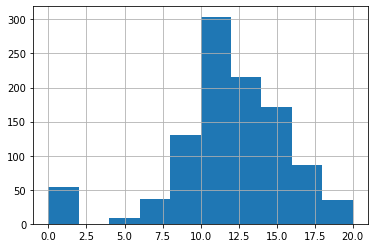

In [10]:
# distribution of response variable
df["G3"].hist()

In [11]:
temp = df["class"].value_counts()
tempdf = pd.DataFrame({"class": temp.index, "values": temp.values})

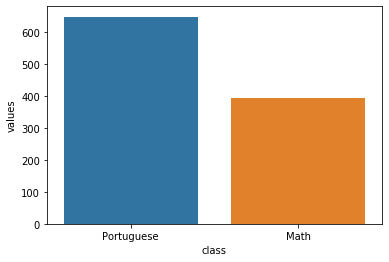

In [12]:
sns.barplot(x="class", y="values",data=tempdf)

# Feature Engineering

In [9]:
# get dummies
df_grades = pd.get_dummies(df, drop_first=True)

In [10]:
df_grades.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,class_Portuguese
0,18,4,4,2,2,0,4,3,4,1,...,0,1,0,0,0,1,1,0,0,0
1,17,1,1,1,2,0,5,3,3,1,...,0,0,1,0,0,0,1,1,0,0
2,15,1,1,1,2,3,4,3,2,2,...,0,1,0,1,0,1,1,1,0,0
3,15,4,2,1,3,0,3,2,2,1,...,0,0,1,1,1,1,1,1,1,0
4,16,3,3,1,2,0,4,3,2,1,...,0,0,1,1,0,1,1,0,0,0


# EDA Continued

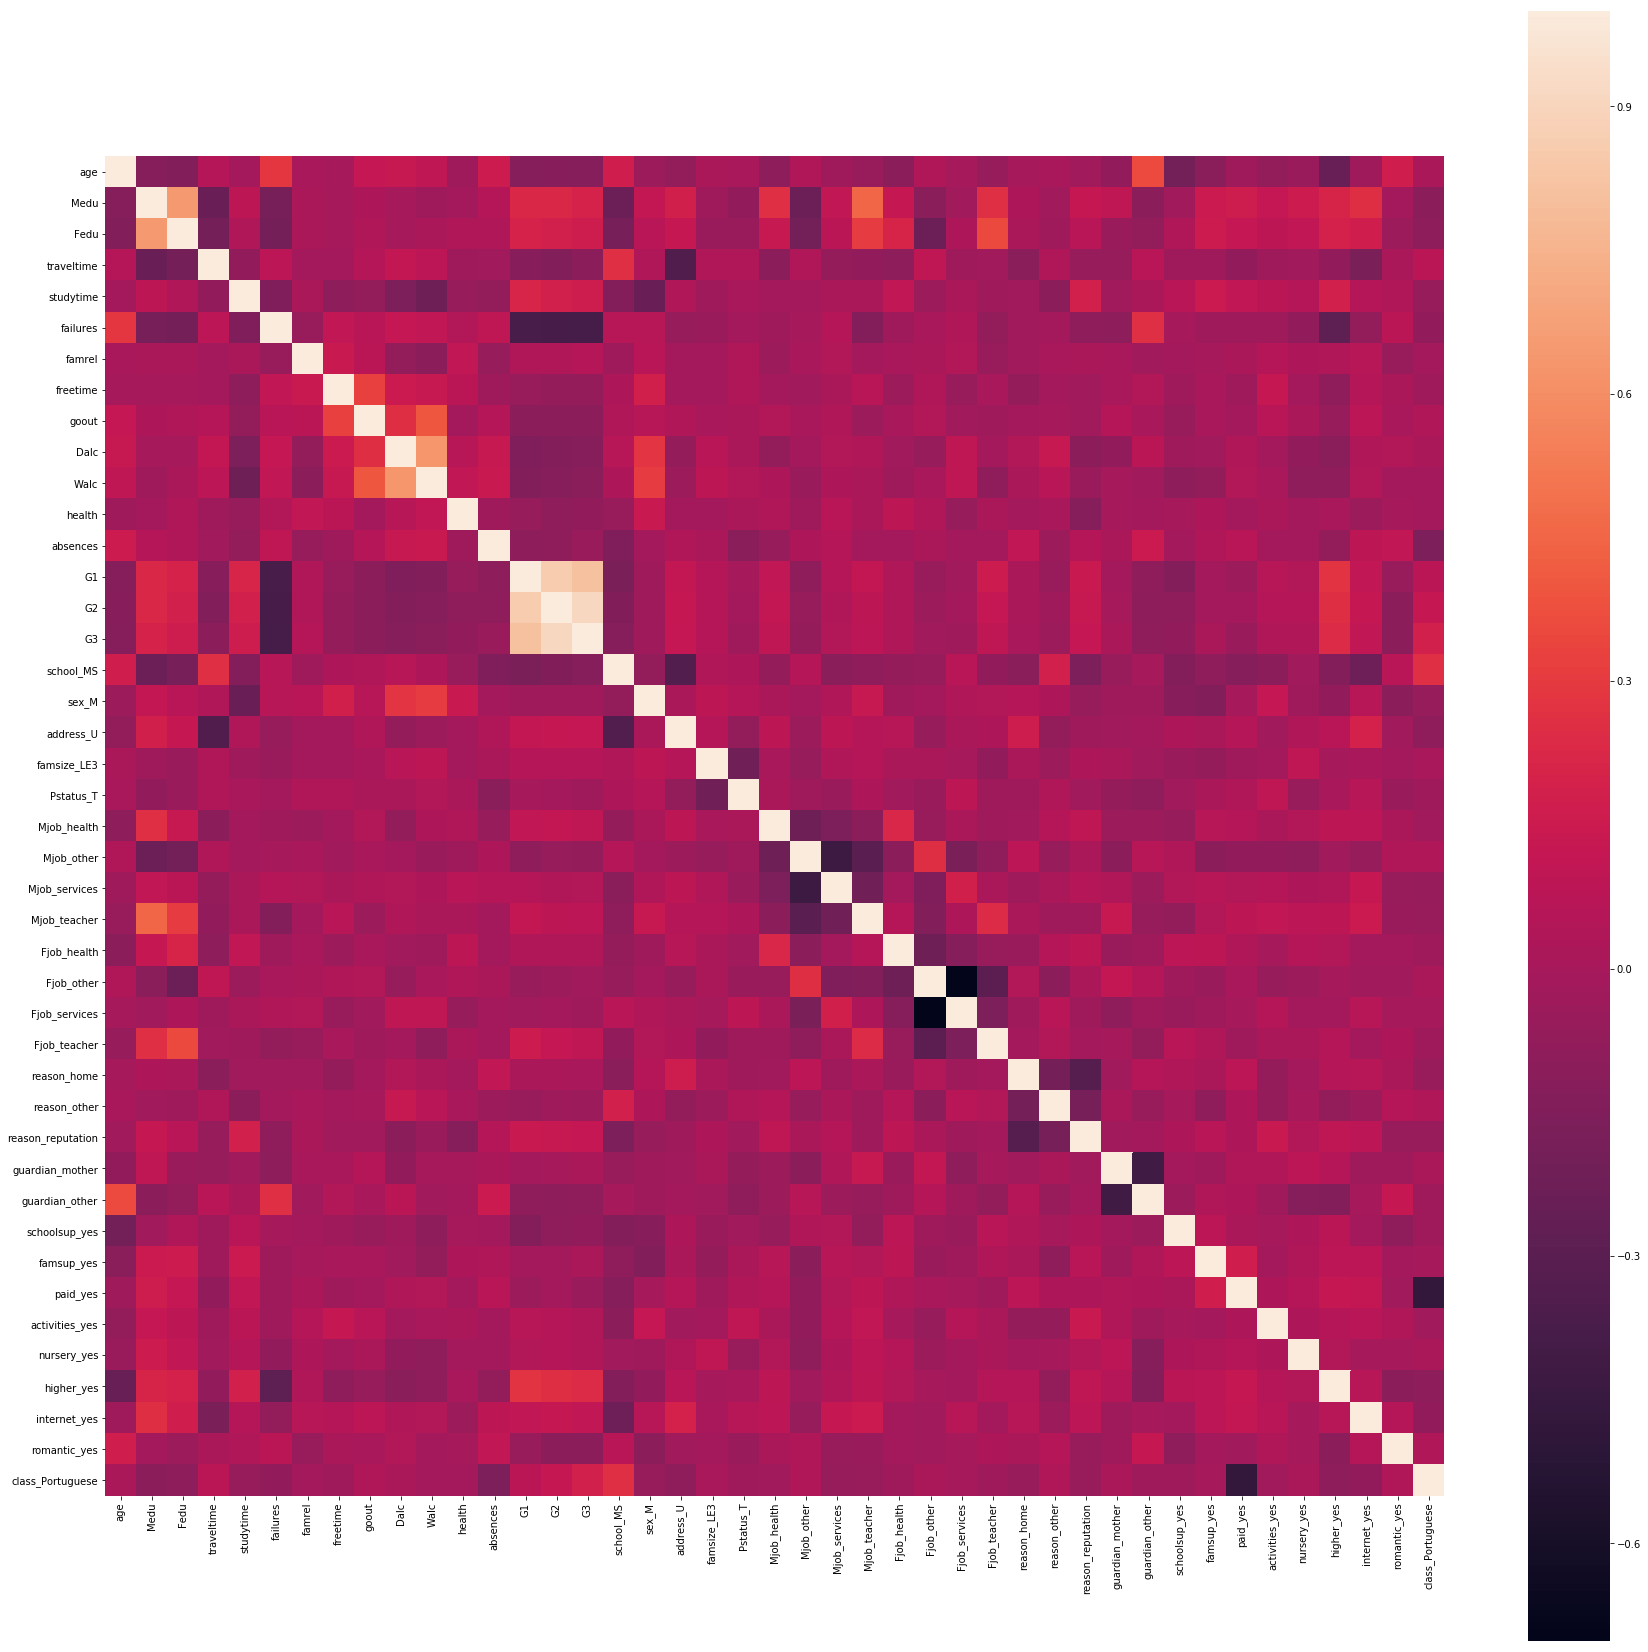

In [15]:
corr = df_grades.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr,square=True)

In [16]:
n = 10
corr.nlargest(n,"G3")["G3"].index

Index(['G3', 'G2', 'G1', 'higher_yes', 'Medu', 'class_Portuguese', 'studytime',
       'Fedu', 'reason_reputation', 'address_U'],
      dtype='object')

# 1. Predict Final Grade

Regression 

In [11]:
y = df_grades["G3"]
X = df_grades.drop(["G3"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=832)

In [12]:
reg=LinearRegression().fit(X_train,y_train)

reg.score(X_train,y_train)

0.8496616599985415

In [13]:
#root mean sqared error
sqrt(cross_val_score(reg, X_test, y_test, scoring='neg_mean_squared_error', cv=10).mean()*-1)

1.689717202413762

In [14]:
#mean absolute error
cross_val_score(reg, X_test, y_test, scoring='neg_mean_absolute_error', cv=10).mean()*-1

1.119091705903054

In [15]:
# mean squared error
cross_val_score(reg, X_test, y_test, scoring='neg_median_absolute_error', cv=10).mean()*-1

0.8200430399022629

Lasso Regression

In [24]:
# instantiate and fit model to find alpha
lassocv = LassoCV(alphas=None, n_alphas=200,cv=10, max_iter=100000, random_state=1)
lassocv.fit(X_train, y_train)
# print alpha
print(lassocv.alpha_)

0.06036066298916316


In [25]:
# fit model with chosen alpha level
lasso_cvalpha = Lasso(alpha=lassocv.alpha_)
lasso_cvalpha.fit(X_train, y_train)

Lasso(alpha=0.06036066298916316, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [26]:
#root mean sqared error
sqrt(cross_val_score(lasso_cvalpha, X_test, y_test, scoring='neg_mean_squared_error', cv=10).mean()*-1)

1.586510363537266

In [27]:
#mean absolute error
cross_val_score(lasso_cvalpha, X_test, y_test, scoring='neg_mean_absolute_error', cv=10).mean()*-1

0.9638755619422753

In [28]:
# mean squared error
cross_val_score(lasso_cvalpha, X_test, y_test, scoring='neg_median_absolute_error', cv=10).mean()*-1

0.6595289678495778

Ridge Regression

In [32]:
# instantiate and fit model to find alpha
clf=RidgeCV(alphas=(.1,.5,1,5,10),cv=10).fit(X_train, y_train)

# print alpha
clf.score(X_train,y_train)

0.8493054203986748

In [33]:
#root mean sqared error
sqrt(cross_val_score(clf, X_test, y_test, scoring='neg_mean_squared_error', cv=10).mean()*-1)

/Users/patrickkelly/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/patrickkelly/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/patrickkelly/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/patrickkelly/anaconda3/lib/python3.7/site-

1.6464060672330383

In [34]:
#mean absolute error
cross_val_score(clf, X_test, y_test, scoring='neg_mean_absolute_error', cv=10).mean()*-1

/Users/patrickkelly/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/patrickkelly/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/patrickkelly/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/patrickkelly/anaconda3/lib/python3.7/site-

1.0593738378922402

In [35]:
# mean squared error
cross_val_score(clf, X_test, y_test, scoring='neg_median_absolute_error', cv=10).mean()*-1

/Users/patrickkelly/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/patrickkelly/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/patrickkelly/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/patrickkelly/anaconda3/lib/python3.7/site-

0.7921008422799357

#### Feature Importance

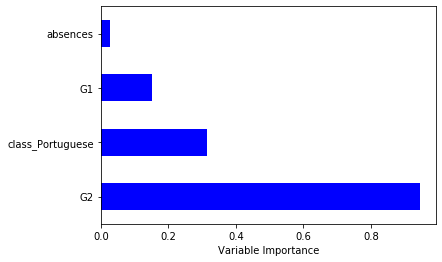

In [40]:
Importance = pd.DataFrame({'Importance':lasso_cvalpha.coef_}, index=X_train.columns)
Importance = Importance.iloc[lasso_cvalpha.coef_ > 0,:]
Importance = Importance.sort_values('Importance', axis=0, ascending=False)[:10]
Importance.plot(kind='barh', color='b', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [41]:
Importance.sort_values('Importance', axis=0, ascending=False)[:10]

,Importance
G2,0.944643
class_Portuguese,0.315509
G1,0.151618
absences,0.028058


## Methods and Results

We used a few regression models in order to predict final grade based off the variables in our data set, including the previous tests. Since we included the previous tests we expected our models to perform well. Lasso regression performed the best, by a small margin over linear regression. Since we used a lot of variables in our analysis lasso helped reduce dimensions and prevent overfitting. The lasso method zeroed out the variables that did not help predict the final grade. The most important feature was the students' score on the second exam.

# 2. Can we predict the final grade without the two previous exam scores?

Regression 

In [16]:
# without first two grades
y = df_grades["G3"]
X = df_grades.drop(["G3","G2","G1"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=832)

**Random Forest**

In [17]:
from sklearn.ensemble import RandomForestRegressor
from math import sqrt

In [18]:
rf = RandomForestRegressor(n_estimators = 100)

In [19]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [20]:
sqrt(cross_val_score(rf, X_train, y_train, scoring='neg_mean_squared_error', cv=10).mean()*-1)

3.208293554874082

In [21]:
y_rf=rf.predict(X_test)

In [22]:
from sklearn.metrics import mean_squared_error
sqrt(mean_squared_error(y_test, y_rf))

3.2489846037514574

**Lasso**

In [23]:
from sklearn.linear_model import LassoCV, Lasso

In [24]:
lassocv = LassoCV(alphas=None, n_alphas=200,cv=10, max_iter=100000, random_state=1)
lassocv.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=100000, n_alphas=200, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=1, selection='cyclic',
        tol=0.0001, verbose=False)

In [25]:
lasso_cvalpha = Lasso(alpha=lassocv.alpha_)
lasso_cvalpha.fit(X_train, y_train)

Lasso(alpha=0.031016867153860095, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [26]:
sqrt(cross_val_score(lasso_cvalpha, X_train, y_train, scoring='neg_mean_squared_error', cv=10).mean()*-1)

3.4232373532474303

In [27]:
y_lass = lasso_cvalpha.predict(X_test)

In [28]:
sqrt(mean_squared_error(y_test, y_lass))

3.400203839761724

**PCA followed by regression**

In [29]:
from sklearn.decomposition import PCA

In [30]:
# options for n_components
n_components = np.arange(1, 20)  
pca_score = []

for n in n_components:
    pca = PCA(n_components=n)
    pca.fit(X_train)
    X_pca = pca.transform(X_train)
    pca_lm = LinearRegression()
    a =cross_val_score(pca_lm, X_pca, y_train, scoring='neg_mean_squared_error',cv=10).mean()
    pca_score.append(a)

In [31]:
n = n_components[np.argmax(pca_score)]
print(n)

18


In [32]:
pca = PCA(n_components=n)
pca.fit(X_train)
X_pca = pca.transform(X_train)
pca_lm = LinearRegression()
pca_lm.fit(X_pca, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
sqrt(cross_val_score(pca_lm, X_pca, y_train, scoring='neg_mean_squared_error', cv=10).mean()*-1)

3.4581948706280987

In [34]:
X_pca_test = pca.transform(X_test)
y_pca=pca_lm.predict(X_pca_test)

In [35]:
sqrt(mean_squared_error(y_test, y_pca))

3.5600908346378795

**Feature Importance**

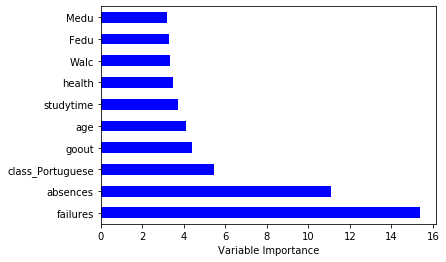

In [36]:
Importance = pd.DataFrame({'Importance':rf.feature_importances_*100}, index=X_train.columns)
Importance = Importance.iloc[rf.feature_importances_ > 0,:]
Importance = Importance.sort_values('Importance', axis=0, ascending=False)[:10]
Importance.plot(kind='barh', color='b', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [37]:
Importance.sort_values('Importance', axis=0, ascending=False)[:10]

,Importance
failures,15.368605
absences,11.071112
class_Portuguese,5.465814
goout,4.404702
age,4.083690
studytime,3.722661
health,3.463566
Walc,3.323774
Fedu,3.292045
Medu,3.207313


## Methods and Results

The models I have selected to train my data are Random Forest, Lasso, and PCA. I chose these methods because they are all regression models that perform well and iterate several times to find the best model, or decomposition of the features. Out of the 3 models, Random Forest performed the best with a smaller RMSE of 3.211. Compared to research question 1., it's clear that the first two exam scores are necessary to accurately predict final exam score. It looks like in this case the top 3 most important features in determining the final grade is the number of past class failures, absences, and whether the class was portuguese or not.

# 3. Can we predict which class it's going to be?

In [26]:
# for classification - can we predict which class it is? math or portuguese?
y = df_grades["class_Portuguese"]
X = df_grades.drop(["class_Portuguese"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=832)

### Logistic Regression with Lasso

In [27]:
loglasso = LogisticRegressionCV(penalty="l1", solver="liblinear",cv=10)
loglasso.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l1',
           random_state=None, refit=True, scoring=None, solver='liblinear',
           tol=0.0001, verbose=0)

In [30]:
print("Accuracy: ",cross_val_score(loglasso, X_train, y_train, scoring='accuracy', cv = 10).mean()*100,2)
print("Precision: ",cross_val_score(loglasso, X_train, y_train, scoring='precision', cv = 10).mean()*100,2)
print("Recall: ",cross_val_score(loglasso, X_train, y_train, scoring='recall', cv = 10).mean()*100,2)
print("F1: ",cross_val_score(loglasso, X_train, y_train, scoring='f1', cv = 10).mean()*100,2)
print("AUC: ",cross_val_score(loglasso, X_train, y_train, scoring='roc_auc', cv = 10).mean()*100,2)

Accuracy:  76.8560512567362 2
Precision:  77.34492154872765 2
Recall:  89.77777777777777 2
F1:  82.98225601555878 2
AUC:  79.59604324821716 2


### Decision Tree

In [31]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [24]:
print("Accuracy: ",cross_val_score(dt, X_train, y_train, scoring='accuracy', cv = 10).mean()*100,2)
print("Precision: ",cross_val_score(dt, X_train, y_train, scoring='precision', cv = 10).mean()*100,2)
print("Recall: ",cross_val_score(dt, X_train, y_train, scoring='recall', cv = 10).mean()*100,2)
print("F1: ",cross_val_score(dt, X_train, y_train, scoring='f1', cv = 10).mean()*100,2)
print("AUC: ",cross_val_score(dt, X_train, y_train, scoring='roc_auc', cv = 10).mean()*100,2)

Accuracy:  71.93194907236003 2
Precision:  78.51811165002964 2
Recall:  74.74396135265702 2
F1:  76.50836616527255 2
AUC:  70.3592132505176 2


### Feature Importance

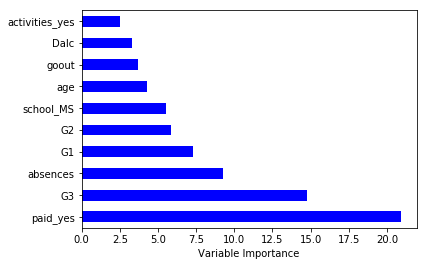

In [40]:
Importance = pd.DataFrame({'Importance':dt.feature_importances_*100}, index=X_train.columns)
Importance = Importance.iloc[dt.feature_importances_ > 0,:]
Importance = Importance.sort_values('Importance', axis=0, ascending=False)[:10]
Importance.plot(kind='barh', color='b', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [41]:
Importance.sort_values('Importance', axis=0, ascending=False)[:10]

,Importance
paid_yes,20.896240
G3,14.791269
absences,9.262302
G1,7.297766
G2,5.859863
school_MS,5.523990
age,4.269259
goout,3.713435
Dalc,3.295300
activities_yes,2.493747


### Random Forest

In [26]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
print("Accuracy: ",cross_val_score(rf, X_train, y_train, scoring='accuracy', cv = 10).mean()*100,2)
print("Precision: ",cross_val_score(rf, X_train, y_train, scoring='precision', cv = 10).mean()*100,2)
print("Recall: ",cross_val_score(rf, X_train, y_train, scoring='recall', cv = 10).mean()*100,2)
print("F1: ",cross_val_score(rf, X_train, y_train, scoring='f1', cv = 10).mean()*100,2)
print("AUC: ",cross_val_score(rf, X_train, y_train, scoring='roc_auc', cv = 10).mean()*100,2)

Accuracy:  74.81241515488091 2
Precision:  77.21054793306637 2
Recall:  85.41545893719807 2
F1:  81.07913262854962 2
AUC:  75.48763834573013 2


## Methods and Results

We used logistic regression with lasso, decision trees, and random forests for this analysis. We didn’t expect to be able to predict which class it was, but the models performed pretty well. We chose to do a lasso logistic regression because it reduces the number of variables by bringing the coefficients close to zero. This model does great with variable selection, but can be unstable because if the data change a lot, the model might select different variables. We also used decision trees, which advantageously don’t require scaling or normalization of data and can help us identify which features are most important. However, decision trees can be slow (though not as slow as random forest). We chose random forest as an ensemble method and it performed better than the decision tree, but not quite as well as logistic regression with lasso. Random forests reduce overfitting and don’t require very many observations for good results. 


# Conclusion

With these models, we learned that it is very difficult to predict a final grade without the input of the first two exams. So while factors such as parents’ education, income, etc. are influential, they are not the only things that influence students’ final exam. This fact can inspire students to work hard because their final exam depends on their own efforts and not just their background. We were able to predict which class students were taking, which is something we would like to explore more if we had more data.
